In [1]:
import sys
sys.path.append("..")


In [2]:
import os
import json
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
import numpy as np

from models.model_v2 import PlantDiseaseResNet18

# ---------- Paths ----------
DATA_ROOT = "/home/ajeet/STRM-SEMESTER-PROJECT/RESNET_Methodology/ResNet_Project/dataset/New Plant Diseases Dataset(Augmented)"

# NOTE: make sure these two actually exist – adjust if needed
TRAIN_DIR = os.path.join(DATA_ROOT, "New Plant Diseases Dataset(Augmented)/train")
VAL_DIR   = os.path.join(DATA_ROOT, "New Plant Diseases Dataset(Augmented)/valid")

MODELS_DIR  = "../models"
RESULTS_DIRMe = "../results"
RESULTS_DIR = "../results/v2_user2"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

MODEL_PATH   = os.path.join(MODELS_DIR, "model_v2.pth")
METRICS_PATH = os.path.join(RESULTS_DIRMe, "metrics_v2.json")

# ---------- Training hyperparameters ----------
BATCH_SIZE = 32
NUM_EPOCHS = 50
LR = 1e-3

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")
if torch.cuda.is_available():
    torch.cuda.set_device(device)
    print(f"Using GPU: {device}")
    print(f"GPU Name: {torch.cuda.get_device_name(device)}")
    
else:
    print("CUDA not available!")
print(f"Running on {device}")


Running on cuda:1
Using GPU: cuda:1
GPU Name: Tesla T4
Running on cuda:1


In [3]:
# Standard ImageNet normalization for ResNet
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=4, pin_memory=True)

class_names = train_dataset.classes
num_classes = len(class_names)
print("Num classes:", num_classes)
print("Example classes:", class_names[:10])


Num classes: 38
Example classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']


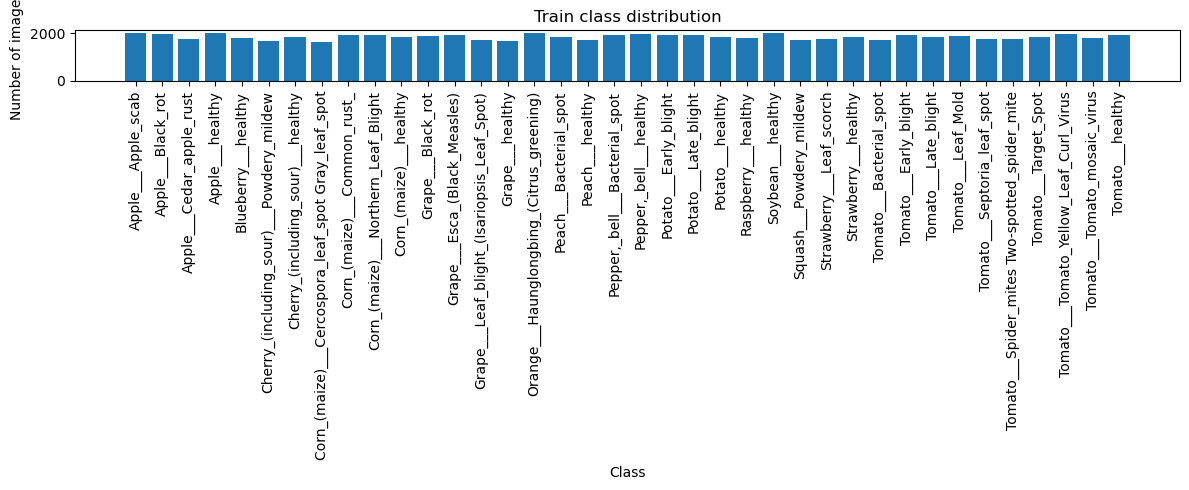

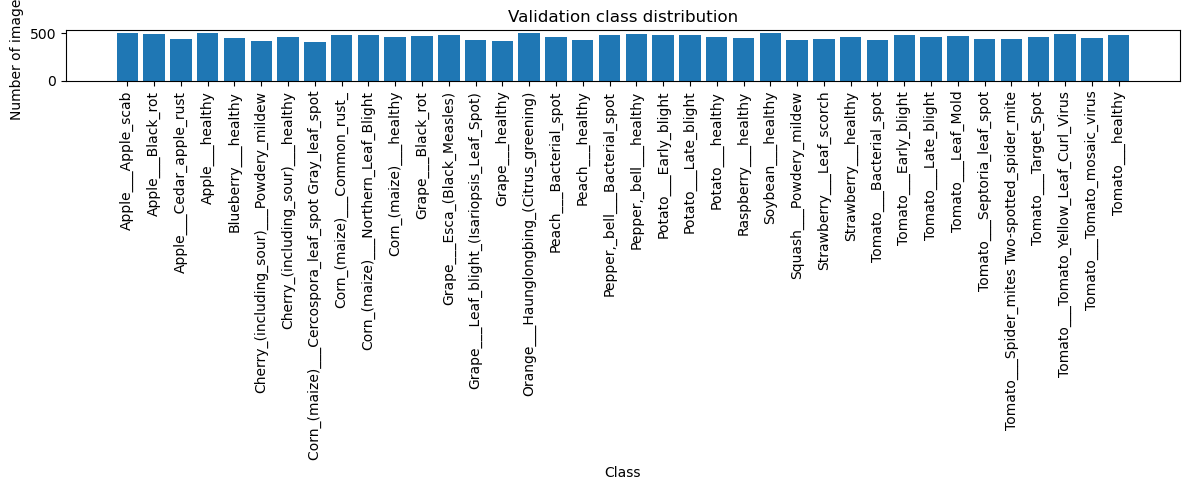

In [4]:
def plot_class_distribution(dataset, title, save_name):
    labels = [label for _, label in dataset.samples]  # list of int labels
    counts = Counter(labels)
    indices = list(range(len(dataset.classes)))
    values = [counts[i] for i in indices]
    names = dataset.classes

    plt.figure(figsize=(12, 5))
    plt.bar(indices, values)
    plt.xticks(indices, names, rotation=90)
    plt.xlabel("Class")
    plt.ylabel("Number of images")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, save_name), dpi=200)
    plt.show()

plot_class_distribution(train_dataset,
                        "Train class distribution",
                        "train_class_distribution_v2.png")

plot_class_distribution(val_dataset,
                        "Validation class distribution",
                        "val_class_distribution_v2.png")


In [5]:
def evaluate(model, loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    running_loss = 0.0
    running_corrects = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels).item()
            total += labels.size(0)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average="macro",
        zero_division=0
    )

    return epoch_loss, epoch_acc, precision, recall, f1


In [6]:

model = PlantDiseaseResNet18(num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_precision": [],
    "val_precision": [],
    "train_recall": [],
    "val_recall": [],
    "train_f1": [],
    "val_f1": []
}

best_val_f1 = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    all_train_preds = []
    all_train_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels).item()
        total += labels.size(0)

        all_train_preds.append(preds.detach().cpu().numpy())
        all_train_labels.append(labels.detach().cpu().numpy())

    epoch_train_loss = running_loss / total
    epoch_train_acc = running_corrects / total

    all_train_preds = np.concatenate(all_train_preds)
    all_train_labels = np.concatenate(all_train_labels)

    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
        all_train_labels,
        all_train_preds,
        average="macro",
        zero_division=0
    )

    # ---- VALIDATION ----
    val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(
        model, val_loader, device
    )

    # ---- Save metrics in history ----
    history["train_loss"].append(epoch_train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(epoch_train_acc)
    history["val_acc"].append(val_acc)
    history["train_precision"].append(train_precision)
    history["val_precision"].append(val_precision)
    history["train_recall"].append(train_recall)
    history["val_recall"].append(val_recall)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    print(f"Train   - loss: {epoch_train_loss:.4f}, "
          f"acc: {epoch_train_acc:.4f}, "
          f"P: {train_precision:.4f}, R: {train_recall:.4f}, F1: {train_f1:.4f}")
    print(f"Valid   - loss: {val_loss:.4f}, "
          f"acc: {val_acc:.4f}, "
          f"P: {val_precision:.4f}, R: {val_recall:.4f}, F1: {val_f1:.4f}")

    # ---- Save best model by val F1 ----
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"** Saved best model_v2.pth with val F1 = {best_val_f1:.4f}")



Epoch 1/50
------------------------------
Train   - loss: 1.7879, acc: 0.4841, P: 0.4770, R: 0.4840, F1: 0.4786
Valid   - loss: 1.1321, acc: 0.6504, P: 0.7350, R: 0.6493, F1: 0.6462
** Saved best model_v2.pth with val F1 = 0.6462

Epoch 2/50
------------------------------
Train   - loss: 0.7585, acc: 0.7637, P: 0.7625, R: 0.7639, F1: 0.7629
Valid   - loss: 0.3321, acc: 0.8897, P: 0.8990, R: 0.8905, F1: 0.8883
** Saved best model_v2.pth with val F1 = 0.8883

Epoch 3/50
------------------------------
Train   - loss: 0.5340, acc: 0.8315, P: 0.8310, R: 0.8317, F1: 0.8312
Valid   - loss: 0.2291, acc: 0.9258, P: 0.9298, R: 0.9259, F1: 0.9250
** Saved best model_v2.pth with val F1 = 0.9250

Epoch 4/50
------------------------------
Train   - loss: 0.4243, acc: 0.8666, P: 0.8661, R: 0.8667, F1: 0.8663
Valid   - loss: 0.2319, acc: 0.9218, P: 0.9324, R: 0.9224, F1: 0.9230

Epoch 5/50
------------------------------
Train   - loss: 0.3576, acc: 0.8872, P: 0.8869, R: 0.8872, F1: 0.8870
Valid   - l

In [7]:
history_serializable = {
    k: [float(x) for x in v] for k, v in history.items()
}
history_serializable["best_val_f1"] = float(best_val_f1)

with open(METRICS_PATH, "w") as f:
    json.dump(history_serializable, f, indent=4)

print("Saved metrics to:", METRICS_PATH)


Saved metrics to: ../results/metrics_v2.json


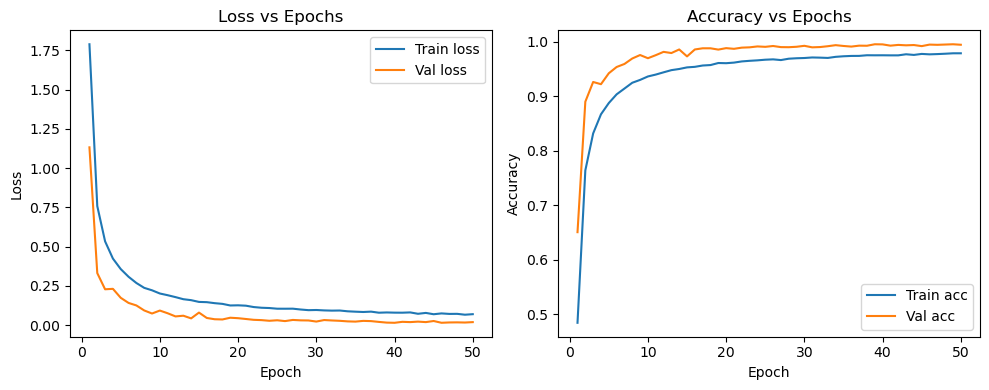

Saved: ../results/v2_user2/loss_accuracy_curves_v2.png


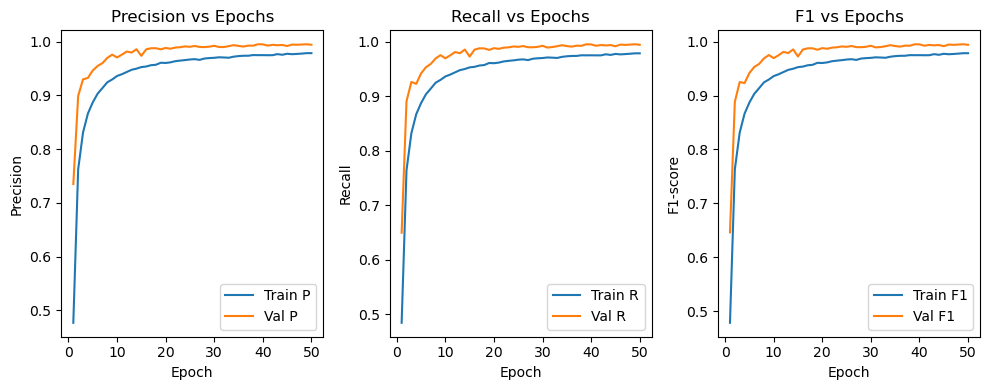

Saved: ../results/v2_user2/precision_recall_f1_curves_v2.png


In [8]:
epochs = range(1, NUM_EPOCHS + 1)

# Loss + Accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train acc")
plt.plot(epochs, history["val_acc"], label="Val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
loss_acc_path = os.path.join(RESULTS_DIR, "loss_accuracy_curves_v2.png")
plt.savefig(loss_acc_path, dpi=200)
plt.show()
print("Saved:", loss_acc_path)

# Precision / Recall / F1
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, history["train_precision"], label="Train P")
plt.plot(epochs, history["val_precision"], label="Val P")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision vs Epochs")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, history["train_recall"], label="Train R")
plt.plot(epochs, history["val_recall"], label="Val R")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall vs Epochs")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, history["train_f1"], label="Train F1")
plt.plot(epochs, history["val_f1"], label="Val F1")
plt.xlabel("Epoch")
plt.ylabel("F1-score")
plt.title("F1 vs Epochs")
plt.legend()

plt.tight_layout()
prf_path = os.path.join(RESULTS_DIR, "precision_recall_f1_curves_v2.png")
plt.savefig(prf_path, dpi=200)
plt.show()
print("Saved:", prf_path)
